In [18]:
from pandas import read_csv
from datetime import datetime
# load data
dataset = read_csv('B_ticker.csv')
# manually specify column names
dataset.columns = ['Date','SellMaxPrice', 'SellMaxVolume','BuyMaxPrice', 'BuyMaxVolume', 'LastTransactionPrice', 'TransactionsVolume', 'MaxPrice', 'MinPrice']
dataset = dataset[dataset > 0]
dataset.index = dataset['Date']
dataset.drop('Date', axis=1, inplace=True)

# drop the first 24 hours
dataset = dataset[(24*12):]
# summarize first 5 rows
display(dataset.head(5))
# save to file
dataset.to_csv('B_ticker copy.csv')

,SellMaxPrice,SellMaxVolume,BuyMaxPrice,BuyMaxVolume,LastTransactionPrice,TransactionsVolume,MaxPrice,MinPrice
Date,,,,,,,,
1510642980,81.004306,1125.251292,81.075142,571.172146,81.004306,81717.73466,83.747596,79.864489
1510643278,80.972108,1016.287263,80.978548,613.064836,80.978548,82222.36282,83.747596,79.864489
1510643578,80.836876,913.204066,80.907712,745.514589,80.907712,82299.82807,83.747596,79.864489
1510643878,81.120220,1212.770252,81.126660,1530.385453,81.068703,84807.94140,83.747596,79.864489
1510644178,80.508454,295.738426,80.559971,1865.380283,80.559971,85732.54516,83.747596,79.864489


In [19]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('B_ticker copy.csv', header=0, index_col=0)
dataset = dataset[dataset>0]
values = dataset.values
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_5mins = 5 *12
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_5mins, 10)

# drop columns we don't want to predict
h = range(480,560)
k = [485,493,501,509,517,525,533,541,549,557]
reframed.drop(reframed.columns[[item for item in h if item not in k]], axis=1, inplace=True)

print("var6(t) is final price in t 5 minitues later")
display(reframed.head(5))

var6(t) is final price in t 5 minitues later


,var1(t-60),var2(t-60),var3(t-60),var4(t-60),var5(t-60),var6(t-60),var7(t-60),var8(t-60),var1(t-59),var2(t-59),...,var6(t),var6(t+1),var6(t+2),var6(t+3),var6(t+4),var6(t+5),var6(t+6),var6(t+7),var6(t+8),var6(t+9)
60,0.870979,0.045917,0.870603,0.025413,0.870197,0.033867,0.93362,0.969994,0.870095,0.041222,...,0.177512,0.188136,0.189363,0.197908,0.200150,0.202875,0.206483,0.220389,0.230431,0.240486
61,0.870095,0.041222,0.867951,0.027466,0.869488,0.035052,0.93362,0.969994,0.866384,0.036780,...,0.188136,0.189363,0.197908,0.200150,0.202875,0.206483,0.220389,0.230431,0.240486,0.261897
62,0.866384,0.036780,0.866007,0.033954,0.867540,0.035234,0.93362,0.969994,0.874161,0.049688,...,0.189363,0.197908,0.200150,0.202875,0.206483,0.220389,0.230431,0.240486,0.261897,0.275518
63,0.874161,0.049688,0.872017,0.072402,0.871968,0.041122,0.93362,0.969994,0.857370,0.010175,...,0.197908,0.200150,0.202875,0.206483,0.220389,0.230431,0.240486,0.261897,0.275518,0.277286
64,0.857370,0.010175,0.856461,0.088812,0.857978,0.043292,0.93362,0.969994,0.856840,0.012328,...,0.200150,0.202875,0.206483,0.220389,0.230431,0.240486,0.261897,0.275518,0.277286,0.279758


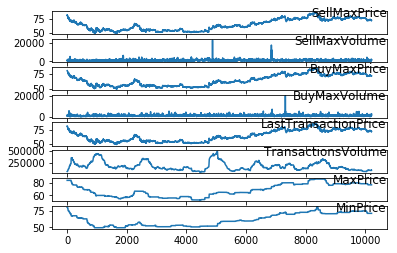

In [20]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('B_ticker copy.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3,4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [21]:
# split into train and test sets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


values = reframed.values
n_obs = n_5mins * n_features
outs = [[0] * 2] * 10
for i in range(10):
    # split into input and outputs
    Testtime = (int)(np.floor((1-0.1)*1498))
    Train = values[0:Testtime,:]
    Test  = values[Testtime:-1,:]
    #train_X, test_X, train_y, test_y = train_test_split(values[:,:n_obs], values[:,-(i+1)], test_size = 0.33, random_state = 42)
    train_X = Train[:,:n_obs]
    train_y = Train[:,-(i+1)]
    test_X = Test[:,:n_obs]
    test_y = Test[:,-(i+1)]
    outs[9-i]=[train_y,test_y]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_5mins, n_features))
test_X = test_X.reshape((test_X.shape[0], n_5mins, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    


(1348, 480) 1348 (1348,)
(1348, 60, 8) (1348,) (7441, 60, 8) (7441,)


Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 4s - loss: 0.3164 - val_loss: 0.3013
Epoch 2/50
 - 2s - loss: 0.1648 - val_loss: 0.1138
Epoch 3/50
 - 2s - loss: 0.0884 - val_loss: 0.0726
Epoch 4/50
 - 2s - loss: 0.0660 - val_loss: 0.0678
Epoch 5/50
 - 2s - loss: 0.0386 - val_loss: 0.0342
Epoch 6/50
 - 2s - loss: 0.0286 - val_loss: 0.0437
Epoch 7/50
 - 2s - loss: 0.0298 - val_loss: 0.0590
Epoch 8/50
 - 2s - loss: 0.0393 - val_loss: 0.0799
Epoch 9/50
 - 2s - loss: 0.0606 - val_loss: 0.0438
Epoch 10/50
 - 2s - loss: 0.0536 - val_loss: 0.0611
Epoch 11/50
 - 2s - loss: 0.0459 - val_loss: 0.0218
Epoch 12/50
 - 2s - loss: 0.0135 - val_loss: 0.0219
Epoch 13/50
 - 2s - loss: 0.0153 - val_loss: 0.0420
Epoch 14/50
 - 2s - loss: 0.0266 - val_loss: 0.0399
Epoch 15/50
 - 2s - loss: 0.0269 - val_loss: 0.0522
Epoch 16/50
 - 2s - loss: 0.0443 - val_loss: 0.0307
Epoch 17/50
 - 2s - loss: 0.0406 - val_loss: 0.0368
Epoch 18/50
 - 2s - loss: 0.0321 - val_loss: 0.0149
Epoch 19/50
 - 2s - loss:

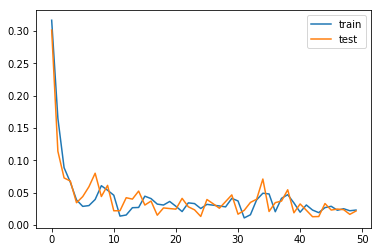

Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 4s - loss: 0.2245 - val_loss: 0.2805
Epoch 2/50
 - 2s - loss: 0.1738 - val_loss: 0.0814
Epoch 3/50
 - 2s - loss: 0.0865 - val_loss: 0.0737
Epoch 4/50
 - 2s - loss: 0.0436 - val_loss: 0.0660
Epoch 5/50
 - 2s - loss: 0.0580 - val_loss: 0.0669
Epoch 6/50
 - 2s - loss: 0.0719 - val_loss: 0.1120
Epoch 7/50
 - 2s - loss: 0.0649 - val_loss: 0.0374
Epoch 8/50
 - 2s - loss: 0.0611 - val_loss: 0.0738
Epoch 9/50
 - 2s - loss: 0.0812 - val_loss: 0.1161
Epoch 10/50
 - 2s - loss: 0.0703 - val_loss: 0.0384
Epoch 11/50
 - 2s - loss: 0.0502 - val_loss: 0.0453
Epoch 12/50
 - 2s - loss: 0.0585 - val_loss: 0.0834
Epoch 13/50
 - 2s - loss: 0.0518 - val_loss: 0.0271
Epoch 14/50
 - 2s - loss: 0.0439 - val_loss: 0.0508
Epoch 15/50
 - 2s - loss: 0.0636 - val_loss: 0.0963
Epoch 16/50
 - 2s - loss: 0.0654 - val_loss: 0.0410
Epoch 17/50
 - 2s - loss: 0.0429 - val_loss: 0.0370
Epoch 18/50
 - 2s - loss: 0.0471 - val_loss: 0.0669
Epoch 19/50
 - 2s - loss:

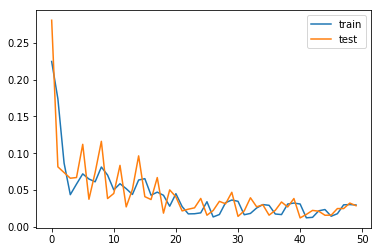

Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 4s - loss: 0.2280 - val_loss: 0.2932
Epoch 2/50
 - 2s - loss: 0.1805 - val_loss: 0.0761
Epoch 3/50
 - 2s - loss: 0.1069 - val_loss: 0.1426
Epoch 4/50
 - 2s - loss: 0.0695 - val_loss: 0.0889
Epoch 5/50
 - 2s - loss: 0.1151 - val_loss: 0.0641
Epoch 6/50
 - 2s - loss: 0.0767 - val_loss: 0.1047
Epoch 7/50
 - 2s - loss: 0.0617 - val_loss: 0.0512
Epoch 8/50
 - 2s - loss: 0.0539 - val_loss: 0.0510
Epoch 9/50
 - 2s - loss: 0.0573 - val_loss: 0.0708
Epoch 10/50
 - 2s - loss: 0.0375 - val_loss: 0.0391
Epoch 11/50
 - 2s - loss: 0.0554 - val_loss: 0.0734
Epoch 12/50
 - 2s - loss: 0.0765 - val_loss: 0.1155
Epoch 13/50
 - 2s - loss: 0.0647 - val_loss: 0.0479
Epoch 14/50
 - 2s - loss: 0.0559 - val_loss: 0.0414
Epoch 15/50
 - 2s - loss: 0.0473 - val_loss: 0.0635
Epoch 16/50
 - 2s - loss: 0.0336 - val_loss: 0.0291
Epoch 17/50
 - 2s - loss: 0.0426 - val_loss: 0.0603
Epoch 18/50
 - 2s - loss: 0.0580 - val_loss: 0.0829
Epoch 19/50
 - 2s - loss:

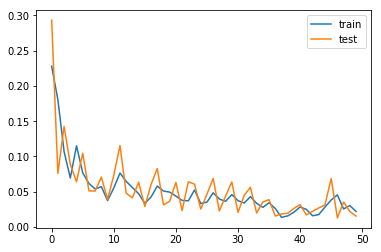

Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 4s - loss: 0.3472 - val_loss: 0.4493
Epoch 2/50
 - 2s - loss: 0.2409 - val_loss: 0.1753
Epoch 3/50
 - 2s - loss: 0.1276 - val_loss: 0.1123
Epoch 4/50
 - 2s - loss: 0.0974 - val_loss: 0.0837
Epoch 5/50
 - 2s - loss: 0.0681 - val_loss: 0.0673
Epoch 6/50
 - 2s - loss: 0.0383 - val_loss: 0.0695
Epoch 7/50
 - 2s - loss: 0.0403 - val_loss: 0.0561
Epoch 8/50
 - 2s - loss: 0.0531 - val_loss: 0.0764
Epoch 9/50
 - 2s - loss: 0.0902 - val_loss: 0.1058
Epoch 10/50
 - 2s - loss: 0.0499 - val_loss: 0.0751
Epoch 11/50
 - 2s - loss: 0.0823 - val_loss: 0.0695
Epoch 12/50
 - 2s - loss: 0.0832 - val_loss: 0.1391
Epoch 13/50
 - 2s - loss: 0.0663 - val_loss: 0.0394
Epoch 14/50
 - 2s - loss: 0.0445 - val_loss: 0.0589
Epoch 15/50
 - 2s - loss: 0.0727 - val_loss: 0.0962
Epoch 16/50
 - 2s - loss: 0.0483 - val_loss: 0.0382
Epoch 17/50
 - 2s - loss: 0.0537 - val_loss: 0.0615
Epoch 18/50
 - 2s - loss: 0.0722 - val_loss: 0.0968
Epoch 19/50
 - 2s - loss:

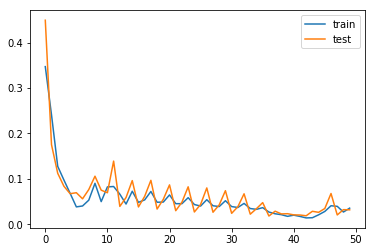

Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 4s - loss: 0.2914 - val_loss: 0.3318
Epoch 2/50
 - 2s - loss: 0.1791 - val_loss: 0.0881
Epoch 3/50
 - 2s - loss: 0.0943 - val_loss: 0.0913
Epoch 4/50
 - 2s - loss: 0.0532 - val_loss: 0.1047
Epoch 5/50
 - 2s - loss: 0.0800 - val_loss: 0.0607
Epoch 6/50
 - 2s - loss: 0.0723 - val_loss: 0.1130
Epoch 7/50
 - 2s - loss: 0.0672 - val_loss: 0.0466
Epoch 8/50
 - 2s - loss: 0.0603 - val_loss: 0.0839
Epoch 9/50
 - 2s - loss: 0.0852 - val_loss: 0.1151
Epoch 10/50
 - 2s - loss: 0.0722 - val_loss: 0.0459
Epoch 11/50
 - 2s - loss: 0.0541 - val_loss: 0.0466
Epoch 12/50
 - 2s - loss: 0.0590 - val_loss: 0.0808
Epoch 13/50
 - 2s - loss: 0.0449 - val_loss: 0.0303
Epoch 14/50
 - 2s - loss: 0.0354 - val_loss: 0.0595
Epoch 15/50
 - 2s - loss: 0.0678 - val_loss: 0.0997
Epoch 16/50
 - 2s - loss: 0.0572 - val_loss: 0.0339
Epoch 17/50
 - 2s - loss: 0.0463 - val_loss: 0.0427
Epoch 18/50
 - 2s - loss: 0.0542 - val_loss: 0.0749
Epoch 19/50
 - 2s - loss:

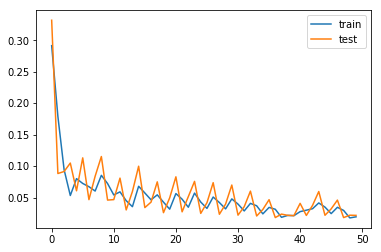

Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 4s - loss: 0.1864 - val_loss: 0.3074
Epoch 2/50
 - 2s - loss: 0.1897 - val_loss: 0.0767
Epoch 3/50
 - 2s - loss: 0.0863 - val_loss: 0.0680
Epoch 4/50
 - 2s - loss: 0.0443 - val_loss: 0.0650
Epoch 5/50
 - 2s - loss: 0.0811 - val_loss: 0.0555
Epoch 6/50
 - 2s - loss: 0.0701 - val_loss: 0.1186
Epoch 7/50
 - 2s - loss: 0.0626 - val_loss: 0.0347
Epoch 8/50
 - 2s - loss: 0.0723 - val_loss: 0.0949
Epoch 9/50
 - 2s - loss: 0.0888 - val_loss: 0.1278
Epoch 10/50
 - 2s - loss: 0.0595 - val_loss: 0.0316
Epoch 11/50
 - 2s - loss: 0.0570 - val_loss: 0.0506
Epoch 12/50
 - 2s - loss: 0.0634 - val_loss: 0.0865
Epoch 13/50
 - 2s - loss: 0.0475 - val_loss: 0.0264
Epoch 14/50
 - 2s - loss: 0.0570 - val_loss: 0.0585
Epoch 15/50
 - 2s - loss: 0.0606 - val_loss: 0.0855
Epoch 16/50
 - 2s - loss: 0.0477 - val_loss: 0.0236
Epoch 17/50
 - 2s - loss: 0.0487 - val_loss: 0.0508
Epoch 18/50
 - 2s - loss: 0.0531 - val_loss: 0.0708
Epoch 19/50
 - 2s - loss:

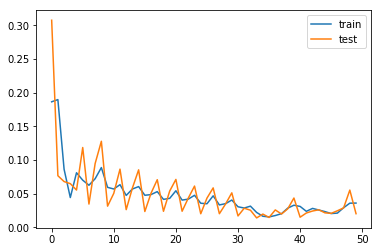

Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 4s - loss: 0.2896 - val_loss: 0.4045
Epoch 2/50
 - 2s - loss: 0.2228 - val_loss: 0.1669
Epoch 3/50
 - 2s - loss: 0.1187 - val_loss: 0.1179
Epoch 4/50
 - 2s - loss: 0.0843 - val_loss: 0.1476
Epoch 5/50
 - 2s - loss: 0.0851 - val_loss: 0.0904
Epoch 6/50
 - 2s - loss: 0.0901 - val_loss: 0.1191
Epoch 7/50
 - 2s - loss: 0.0801 - val_loss: 0.0667
Epoch 8/50
 - 2s - loss: 0.0612 - val_loss: 0.0603
Epoch 9/50
 - 2s - loss: 0.0542 - val_loss: 0.0464
Epoch 10/50
 - 2s - loss: 0.0377 - val_loss: 0.0382
Epoch 11/50
 - 2s - loss: 0.0332 - val_loss: 0.0373
Epoch 12/50
 - 2s - loss: 0.0425 - val_loss: 0.0516
Epoch 13/50
 - 2s - loss: 0.0555 - val_loss: 0.0574
Epoch 14/50
 - 2s - loss: 0.0345 - val_loss: 0.0328
Epoch 15/50
 - 2s - loss: 0.0432 - val_loss: 0.0405
Epoch 16/50
 - 2s - loss: 0.0417 - val_loss: 0.0402
Epoch 17/50
 - 2s - loss: 0.0311 - val_loss: 0.0243
Epoch 18/50
 - 2s - loss: 0.0234 - val_loss: 0.0445
Epoch 19/50
 - 2s - loss:

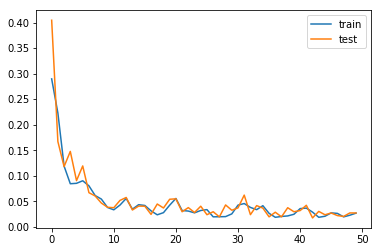

Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 5s - loss: 0.2729 - val_loss: 0.2804
Epoch 2/50
 - 2s - loss: 0.1619 - val_loss: 0.1004
Epoch 3/50
 - 2s - loss: 0.0846 - val_loss: 0.0609
Epoch 4/50
 - 2s - loss: 0.0466 - val_loss: 0.0461
Epoch 5/50
 - 2s - loss: 0.0383 - val_loss: 0.0487
Epoch 6/50
 - 2s - loss: 0.0329 - val_loss: 0.0445
Epoch 7/50
 - 2s - loss: 0.0413 - val_loss: 0.0569
Epoch 8/50
 - 2s - loss: 0.0627 - val_loss: 0.0558
Epoch 9/50
 - 2s - loss: 0.0359 - val_loss: 0.0426
Epoch 10/50
 - 2s - loss: 0.0441 - val_loss: 0.0703
Epoch 11/50
 - 2s - loss: 0.0529 - val_loss: 0.0321
Epoch 12/50
 - 2s - loss: 0.0298 - val_loss: 0.0357
Epoch 13/50
 - 2s - loss: 0.0422 - val_loss: 0.0497
Epoch 14/50
 - 2s - loss: 0.0577 - val_loss: 0.0578
Epoch 15/50
 - 2s - loss: 0.0363 - val_loss: 0.0381
Epoch 16/50
 - 2s - loss: 0.0364 - val_loss: 0.0467
Epoch 17/50
 - 2s - loss: 0.0370 - val_loss: 0.0418
Epoch 18/50
 - 2s - loss: 0.0319 - val_loss: 0.0296
Epoch 19/50
 - 2s - loss:

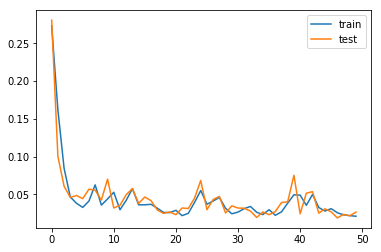

Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 5s - loss: 0.2054 - val_loss: 0.2766
Epoch 2/50
 - 2s - loss: 0.1502 - val_loss: 0.0755
Epoch 3/50
 - 2s - loss: 0.0625 - val_loss: 0.0614
Epoch 4/50
 - 2s - loss: 0.0614 - val_loss: 0.0420
Epoch 5/50
 - 2s - loss: 0.0387 - val_loss: 0.0286
Epoch 6/50
 - 2s - loss: 0.0281 - val_loss: 0.0599
Epoch 7/50
 - 2s - loss: 0.0463 - val_loss: 0.0428
Epoch 8/50
 - 2s - loss: 0.0455 - val_loss: 0.0433
Epoch 9/50
 - 2s - loss: 0.0506 - val_loss: 0.0425
Epoch 10/50
 - 2s - loss: 0.0336 - val_loss: 0.0282
Epoch 11/50
 - 2s - loss: 0.0244 - val_loss: 0.0359
Epoch 12/50
 - 2s - loss: 0.0254 - val_loss: 0.0279
Epoch 13/50
 - 2s - loss: 0.0384 - val_loss: 0.0358
Epoch 14/50
 - 2s - loss: 0.0464 - val_loss: 0.0371
Epoch 15/50
 - 2s - loss: 0.0396 - val_loss: 0.0335
Epoch 16/50
 - 2s - loss: 0.0275 - val_loss: 0.0226
Epoch 17/50
 - 2s - loss: 0.0258 - val_loss: 0.0462
Epoch 18/50
 - 2s - loss: 0.0295 - val_loss: 0.0341
Epoch 19/50
 - 2s - loss:

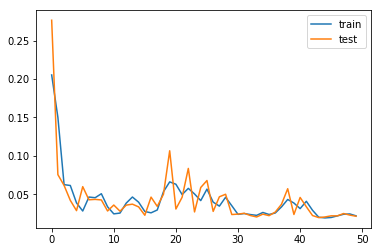

Train on 1348 samples, validate on 7441 samples
Epoch 1/50
 - 5s - loss: 0.2095 - val_loss: 0.3213
Epoch 2/50
 - 2s - loss: 0.1811 - val_loss: 0.1075
Epoch 3/50
 - 2s - loss: 0.0789 - val_loss: 0.0535
Epoch 4/50
 - 2s - loss: 0.0579 - val_loss: 0.0585
Epoch 5/50
 - 2s - loss: 0.0736 - val_loss: 0.0942
Epoch 6/50
 - 2s - loss: 0.0559 - val_loss: 0.0627
Epoch 7/50
 - 2s - loss: 0.0580 - val_loss: 0.0705
Epoch 8/50
 - 2s - loss: 0.0782 - val_loss: 0.0962
Epoch 9/50
 - 2s - loss: 0.0535 - val_loss: 0.0509
Epoch 10/50
 - 2s - loss: 0.0674 - val_loss: 0.0496
Epoch 11/50
 - 2s - loss: 0.0606 - val_loss: 0.0793
Epoch 12/50
 - 2s - loss: 0.0435 - val_loss: 0.0347
Epoch 13/50
 - 2s - loss: 0.0547 - val_loss: 0.0858
Epoch 14/50
 - 2s - loss: 0.0769 - val_loss: 0.1032
Epoch 15/50
 - 2s - loss: 0.0557 - val_loss: 0.0346
Epoch 16/50
 - 2s - loss: 0.0502 - val_loss: 0.0460
Epoch 17/50
 - 2s - loss: 0.0571 - val_loss: 0.0787
Epoch 18/50
 - 2s - loss: 0.0457 - val_loss: 0.0303
Epoch 19/50
 - 2s - loss:

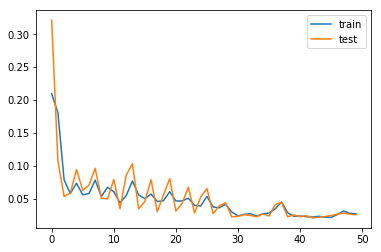

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings("ignore")
# design network
models = []
for i in range(10):
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    models.append(model)
for j in range(10):
    # fit network
    history = models[j].fit(train_X, outs[j][0], epochs=50, batch_size=72, validation_data=(test_X, outs[j][1]), verbose=2, shuffle=False);
    # plot history
    pyplot.plot(history.history['loss'], label='train');
    pyplot.plot(history.history['val_loss'], label='test');
    pyplot.legend();
    pyplot.show()

In [25]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# save the model to disk
Sum=0

for i in range(10):
    models[i].save(str(5*(i+1))+'finalized_model.model')
    # make a prediction
    yhat = models[i].predict(test_X)
    
    reshaped_test_X = test_X.reshape((test_X.shape[0], n_5mins*n_features))
    
    # invert scaling for forecast
    #inv_yhat = concatenate((yhat, reshaped_test_X[:, -7:]), axis=1)
    #inv_yhat = scaler.inverse_transform(inv_yhat)
    #inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    #test_y = outs[i][1].reshape((len(outs[i][1]), 1))
    #inv_y = concatenate((test_y, reshaped_test_X[:, -7:]), axis=1)
    #inv_y = scaler.inverse_transform(inv_y)
    #inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(outs[i][1], yhat))
    print('RMSE of final prices model for '+str(5*(i+1))+' minutes later: %.3f'%rmse) 
    Sum+=rmse
    #clfreg = LinearRegression()
    #clfreg1 = LinearRegression()
    #clfreg.fit(reshaped_test_X[:,-3], inv_y)
    #y_pred=clfreg.predict(reshaped_test_X[:,-3])
    #clfreg1.fit(reshaped_test_X[:,-3], inv_yhat)
    #y_pred1=clfreg1.predict(reshaped_test_X[:,-3])
    #plt.plot(reshaped_test_X[:,-3], y_pred , 'c',label='original price')
    #plt.plot(reshaped_test_X[:,-3],y_pred1 , 'r',label='predicted price')
    #plt.xlabel('Area');
    #plt.ylabel('Price');
    #pyplot.legend();
    #plt.show();
print('Total RMSE of final prices models: %.3f'%(Sum/10))  


RMSE of final prices model for 5 minutes later: 0.028
RMSE of final prices model for 10 minutes later: 0.042
RMSE of final prices model for 15 minutes later: 0.021
RMSE of final prices model for 20 minutes later: 0.040
RMSE of final prices model for 25 minutes later: 0.031
RMSE of final prices model for 30 minutes later: 0.026
RMSE of final prices model for 35 minutes later: 0.036
RMSE of final prices model for 40 minutes later: 0.034
RMSE of final prices model for 45 minutes later: 0.030
RMSE of final prices model for 50 minutes later: 0.036
Total RMSE of final prices models: 0.032


In [26]:
#print(test_X[:,5])
mape = (abs(outs[0][1]-yhat)/outs[0][1]).mean()
a = test_y
b= a[a==0]
#print(b)
print(mape)
#print(outs[0][1])
#print(yhat)

1.3158387
